<a href="https://colab.research.google.com/github/Abtin-Ghorbani/mastrs_project_XAI_pneumonia_detection/blob/main/masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dawnload dataset from Kaggle**

In [1]:
from google.colab import drive
import os
import shutil
import kagglehub
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q Kaggle
from google.colab import files
files.upload()
import os
# فقط در صورت نبود فایل zip، دانلود کن
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print(" Dataset ZIP already exists")
# فقط اگر فولدر chest_xray نیست، unzip کن
if not os.path.exists("dataset/chest_xray"):
    !unzip -q chest-xray-pneumonia.zip -d dataset
else:
    print(" Dataset already extracted")
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#  دانلود فقط اگر فایل ZIP هنوز وجود نداره
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print("Dataset ZIP already exists")

# ✅ استخراج فقط اگر فولدر اصلی chest_xray هنوز ساخته نشده
if not os.path.exists("dataset/chest_xray"):
    !unzip -n chest-xray-pneumonia.zip -d dataset
    !rm -rf dataset/__MACOSX  # حذف فایل‌های مزاحم مک
else:
    print("Dataset already extracted")


Streaming output truncated to the last 5000 lines.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: d

In [3]:
import os

base_dir = '/content/dataset/chest_xray'
print(os.listdir(base_dir))#folder names

['val', 'train', 'chest_xray', '__MACOSX', 'test']


# **task 1 data preproccessing**

In [4]:
import os
import shutil
import random

# مسیر داده‌های اصلی و مسیر ذخیره‌ی داده‌های جدید
base_dir = 'dataset/chest_xray'
new_base = 'dataset/chest_xray_balanced'

# ساخت پوشه‌ی جدید اگه وجود نداره
os.makedirs(new_base, exist_ok=True)


In [5]:
normal_all = []
pneumonia_all = []

for folder in ['train', 'test', 'val']:
    normal_path = os.path.join(base_dir, folder, 'NORMAL')
    pneumonia_path = os.path.join(base_dir, folder, 'PNEUMONIA')

    normal_all += [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_all += [os.path.join(pneumonia_path, f) for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]


In [6]:
min_len = min(len(normal_all), len(pneumonia_all))

normal_all = random.sample(normal_all, min_len)
pneumonia_all = random.sample(pneumonia_all, min_len)

print(f"✅ After balancing: {len(normal_all)} NORMAL and {len(pneumonia_all)} PNEUMONIA")


✅ After balancing: 1583 NORMAL and 1583 PNEUMONIA


In [7]:
def split_data(file_list, train_ratio=0.7, val_ratio=0.2):
    random.shuffle(file_list)
    total = len(file_list)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    return file_list[:train_end], file_list[train_end:val_end], file_list[val_end:]

normal_train, normal_val, normal_test = split_data(normal_all)
pneumonia_train, pneumonia_val, pneumonia_test = split_data(pneumonia_all)


In [8]:
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# مسیرهای خروجی نهایی
for label, train, val, test in zip(
    ['NORMAL', 'PNEUMONIA'],
    [normal_train, pneumonia_train],
    [normal_val, pneumonia_val],
    [normal_test, pneumonia_test]
):
    copy_files(train, os.path.join(new_base, 'train', label))
    copy_files(val, os.path.join(new_base, 'val', label))
    copy_files(test, os.path.join(new_base, 'test', label))


In [9]:
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, label)
        print(f"{split.upper()} - {label}: {len(os.listdir(folder))} images")


TRAIN - NORMAL: 1108 images
TRAIN - PNEUMONIA: 1108 images
VAL - NORMAL: 316 images
VAL - PNEUMONIA: 316 images
TEST - NORMAL: 159 images
TEST - PNEUMONIA: 159 images


In [10]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32
base_dir = 'dataset/chest_xray_balanced'

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'val'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 2216 files belonging to 2 classes.
Found 632 files belonging to 2 classes.
Found 318 files belonging to 2 classes.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for images, labels in train_ds.take(1):  # فقط یک batch می‌گیریم
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # چاپ لیبل‌های واقعی

Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
Labels: [[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]


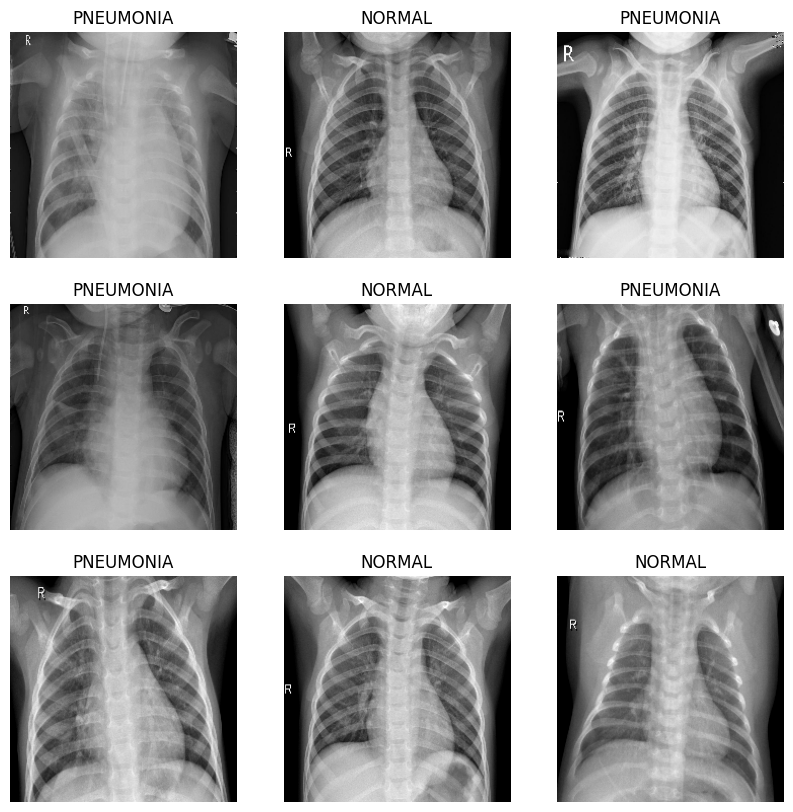

In [13]:
import matplotlib.pyplot as plt

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# **Normalization**

In [14]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [15]:
def preprocess(image, label):
    image = preprocess_input(image)  # between mobile net [-1, 1]
    return image, label
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# **buld and Train CNN model for pneumonia classification**

In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [17]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # فریز کردن وزن‌های مدل

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **buil model **

In [19]:
from tensorflow.keras import layers, Model, Input
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_mobilenet_func = Model(inputs=inputs, outputs=outputs, name="mobilenetv2_functional")

# **compile the model **

In [20]:
# Compile the model with optimizer, loss, and metric
model_mobilenet_func.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',                                # For binary classification
    metrics=['accuracy']
)

In [21]:
model_mobilenet_func.summary()

Model: "mobilenetv2_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

2222# # **train model with images**

In [22]:
# Train the model using early stopping
history = model_mobilenet_func.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.4804 - loss: 0.7703 - val_accuracy: 0.6566 - val_loss: 0.6185
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6355 - loss: 0.6262 - val_accuracy: 0.8085 - val_loss: 0.5129
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7707 - loss: 0.5125 - val_accuracy: 0.8671 - val_loss: 0.4364
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8383 - loss: 0.4417 - val_accuracy: 0.9035 - val_loss: 0.3834
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8582 - loss: 0.4034 - val_accuracy: 0.9035 - val_loss: 0.3437
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8827 - loss: 0.3651 - val_accuracy: 0.9130 - val_loss: 0.3150
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9028 - loss: 0.3253 - val_accuracy: 0.9256 - val_loss: 0.2940
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9005 - loss: 0.3132 - val_accuracy: 0.9193 -

In [23]:
model_mobilenet_func.save("/content/mobilenetv2_functional_trained.keras")

In [24]:
model_mobilenet_func.save("/content/drive/MyDrive/mobilenetv2_functional_trained.keras")

In [34]:
model_mobilenet_func.save("/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")

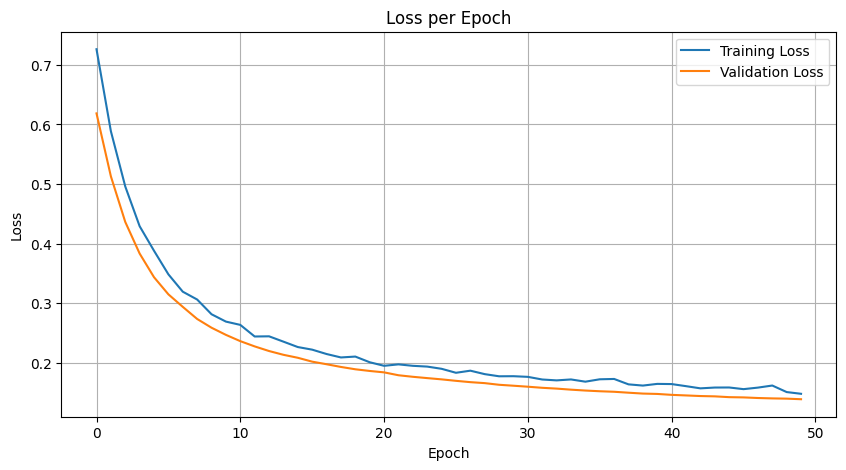

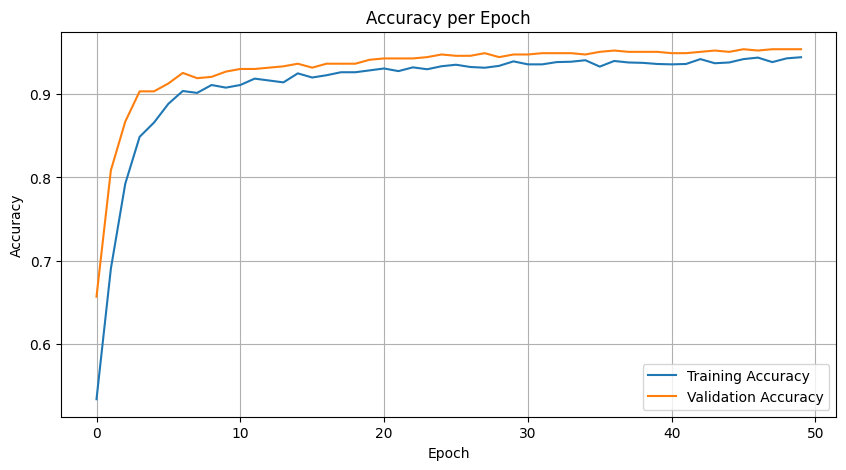

In [25]:
# prompt: write a code to show loss / epoch

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

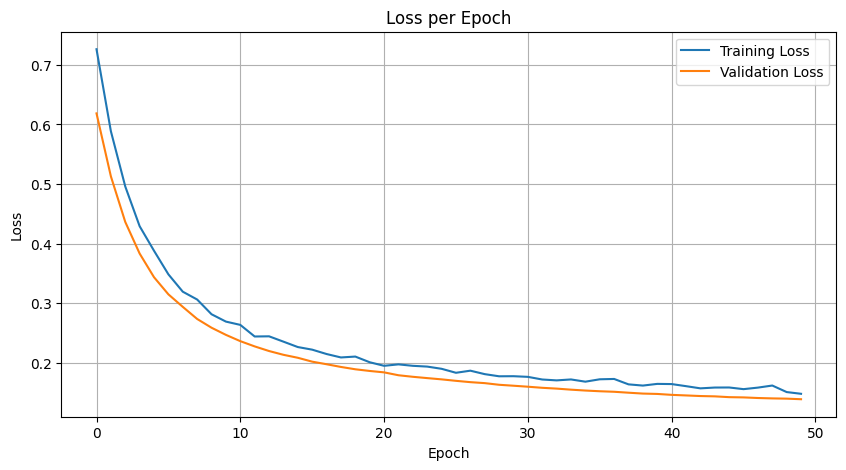

In [26]:
# prompt: write a code to visualize trainig and validation loss chart
import matplotlib.pyplot as plt

# Assuming `history` object from model training is available
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**save model tranfer learning**

In [ ]:
#model_mobilenet.save("mobilenetv2_transfer_only_final.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0.9718696


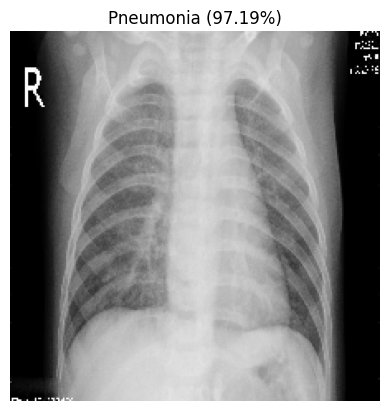

[[0.9718696]]


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load model
model = model_mobilenet_func
# Load and preprocess image
img_path = '/content/dataset/chest_xray_balanced/test/PNEUMONIA/person36_virus_81.jpeg'  # Update path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
print(prediction[0][0])
result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

# Display
plt.imshow(img)
plt.title(f"{result} ({confidence:.2%})")
plt.axis('off')
plt.show()
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.0034249346


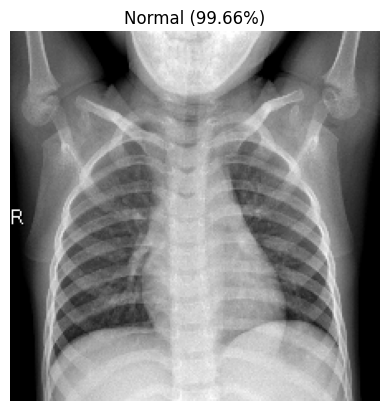

[[0.00342493]]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load model
model = model_mobilenet_func
# Load and preprocess image
img_path = '/content/dataset/chest_xray_balanced/test/NORMAL/NORMAL2-IM-1090-0001.jpeg'  # Update path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
print(prediction[0][0])
result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

# Display
plt.imshow(img)
plt.title(f"{result} ({confidence:.2%})")
plt.axis('off')
plt.show()
print(prediction)

# **evaluate model**

In [29]:
# Evaluate the model on test data
test_loss, test_acc = model_mobilenet_func.evaluate(test_ds)
print(f"Test Accuracy for mobile net: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 840ms/step - accuracy: 0.9273 - loss: 0.1769
Test Accuracy for mobile net: 0.9371


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet_func.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report for transfer learning:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[153   6]
 [ 15 144]]

Classification Report for transfer learning:
              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.94       159
   PNEUMONIA       0.96      0.91      0.93       159

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



In [ ]:
# prompt: write a code to save this model_mobilenet tu goggle drive in this folder /content/drive/MyDrive/masters project

#model_save_path = '/content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras'
#model_mobilenet.save(model_save_path)
#print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras


In [ ]:
from tensorflow.keras.models import load_model
#model_mobilenet_3 = load_model("/content/drive/MyDrive/masters project/mobilenet_balanced_model3.keras")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet_func.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report for transfer learning:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Confusion Matrix:
[[288  16]
 [ 16 298]]

Classification Report for transfer learning:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       304
   PNEUMONIA       0.95      0.95      0.95 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


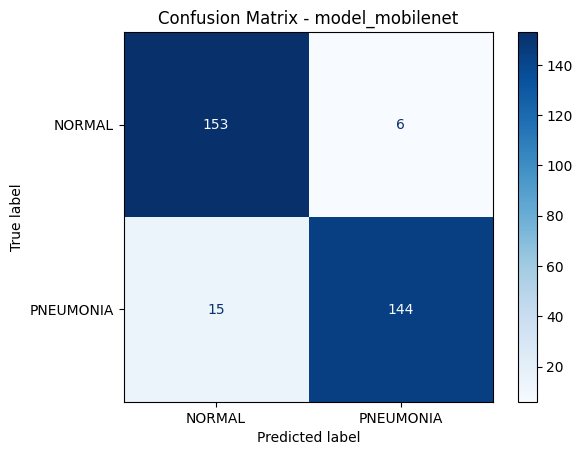


Classification Report for model_mobilenet:
              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.94       159
   PNEUMONIA       0.96      0.91      0.93       159

    accuracy                           0.93       318
   macro avg       0.94      0.93      0.93       318
weighted avg       0.94      0.93      0.93       318



In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Baraye ROC va PR curve ehtiyaj be prob ha darim pas az now sabt mikonim
y_true_befor = []
y_pred_befor = []
y_pred_probs_befor = []

for images, labels in test_ds:
    probs = model_mobilenet_func.predict(images)  # sigmoid output
    preds = (probs > 0.6).astype("int32")  # threshold 0.6
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds)
    y_pred_probs_befor.extend(probs[:, 0])  # flatten

# Confusion Matrix
cm = confusion_matrix(y_true_befor, y_pred_befor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - model_mobilenet")
plt.grid(False)
plt.show()

# Classification Report
print("\nClassification Report for model_mobilenet:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


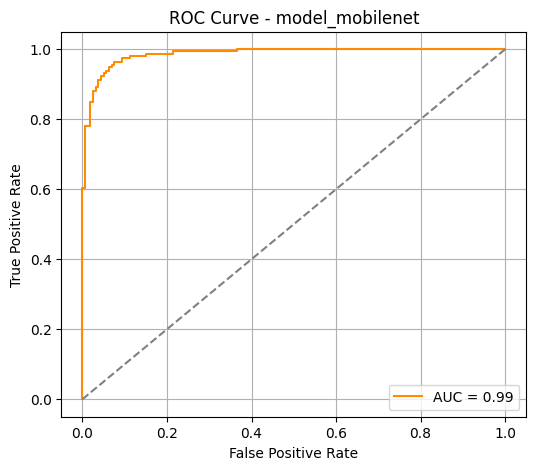

In [32]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_befor, y_pred_probs_befor)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - model_mobilenet')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [35]:
model_mobilenet_func.save(r"/content/drive/MyDrive/masters project/mobilenetv2_functional_trained.keras")

# **feature wxtraction for ML**

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tqdm import tqdm

In [39]:
from tensorflow.keras.models import Model
# گرفتن input از مدل و خروجی درست از لایه GAP
input_tensor = model_mobilenet_func.input
output_tensor = model_mobilenet_func.get_layer("global_avg_pool").output
# ساخت feature extractor
feature_extractor = Model(inputs=input_tensor, outputs=output_tensor)
feature_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
import numpy as np
from tqdm import tqdm

def extract_features_and_labels(dataset):
    features = []
    labels = []
    for images, label_batch in tqdm(dataset, desc="Extracting Features"):
        batch_features = feature_extractor.predict(images, verbose=0)
        features.extend(batch_features)
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)
# اجرا روی train / val / test
train_features, train_labels = extract_features_and_labels(train_ds)
val_features, val_labels = extract_features_and_labels(val_ds)
test_features, test_labels = extract_features_and_labels(test_ds)


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


In [41]:
# ساخت نام ویژگی‌ها (1280 تا)
feature_names = [f"feature_{i+1}" for i in range(train_features.shape[1])]
# ذخیره همه‌چیز در فایل فشرده
np.savez_compressed("/content/drive/MyDrive/cnn_features_balanced_named.npz",
                    train_X=train_features, train_y=train_labels,
                    val_X=val_features, val_y=val_labels,
                    test_X=test_features, test_y=test_labels,
                    feature_names=feature_names)
print("Feature extraction completed and saved")

Feature extraction completed and saved!


In [43]:
import numpy as np

data = np.load("/content/drive/MyDrive/cnn_features_balanced_named.npz")
train_X = data["train_X"]
train_y = data["train_y"]
feature_names = data["feature_names"]  # ['feature_1', 'feature_2', ..., 'feature_1280']

In [44]:
import pandas as pd
# اولین نمونه (مثلاً تصویر اول)
sample_index = 0
sample_features = train_X[sample_index]
# نمایش به صورت جدول با نام فیچرها
df = pd.DataFrame([sample_features], columns=feature_names)
df.T.head(20)  # فقط 20 ویژگی اول

,0
feature_1,0.213764
feature_2,0.000000
feature_3,0.161292
feature_4,1.235999
feature_5,1.096056
feature_6,0.014031
feature_7,0.211297
feature_8,0.060081
feature_9,0.116840
feature_10,0.035404


In [45]:
# Create a DataFrame for plotting
df = pd.DataFrame({
    "feature": feature_names,
    "value": sample_features
})

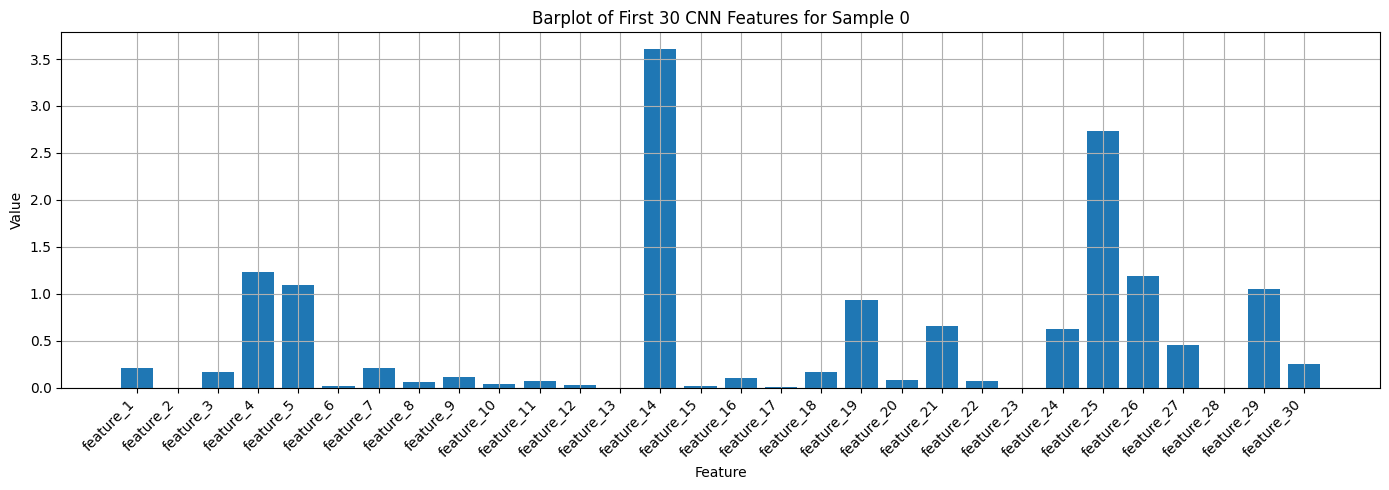

In [46]:
# Plot bar chart for first 30 features
plt.figure(figsize=(14, 5))
plt.bar(df["feature"][:30], df["value"][:30])
plt.xticks(rotation=45, ha='right')
plt.title("Barplot of First 30 CNN Features for Sample 0")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.grid(True)
plt.show()

In [47]:
import numpy as np
data = np.load("/content/drive/MyDrive/cnn_features_balanced_named.npz")
train_X = data['train_X']
train_y = data['train_y']
val_X = data['val_X']
val_y = data['val_y']
test_X = data['test_X']
test_y = data['test_y']
feature_names = data['feature_names']